In [11]:
%run setup.py

In [13]:
# mw_streams = galstreams.MWStreams(verbose=False)
plot_density_healpy.plot_pretty(figsize=(12,12))

In [14]:
def apwnorm(x, min=None, max=None):
    if min is None:
        min = np.nanmin(x[~np.isinf(x)])
    if max is None:
        max = np.nanmax(x[~np.isinf(x)])
    return np.clip((x - min) / (max - min), 0, 1)

In [21]:
z = 0.0001
age = 13.5
gmax = 23.0

hpxcube_south, fracdet_south, modulus = load_data.load_data('DECaLS', z, age, gmax)
hpxcube_north, fracdet_north, modulus = load_data.load_data('BASS', z, age, gmax)

Reading /Users/nora/projects/stream_search/data/DECaLS_iso_hpxcube_z0.0001_a13.5_gmax23.fits.gz...
Reading ../data/DECaLS_nside128.fits.gz...
Reading /Users/nora/projects/stream_search/data/BASS_iso_hpxcube_z0.0001_a13.5_gmax23.fits.gz...
Reading ../data/BASS_nside256.fits.gz...


In [26]:
# cubes = {'bass': hpxcube_north, 'decals': hpxcube_south}
# footprints = {'bass': hpxcube_south, 'decals': fracdet_south}

In [22]:
# npix, nslice = hpxcube_south.shape
# nside = hp.npix2nside(npix)

In [31]:
slices = [(26, 50),
          (15, 26),
          (0, 15)]

slice_str = '_'.join(['{}-{}'.format(x,y) for x,y in slices])
dist = plot_density.mod2dist(modulus)
for x, y in slices:
    print(dist[x], dist[y])

20.892961308540322 63.09573444801878
12.589254117941637 20.892961308540322
6.30957344480193 12.589254117941637


In [201]:
proj = plot_density_healpy.get_ortho_proj(ends=[[5,-5],[15,-5]], half_sky=False)
func = lambda x, y, z: hp.vec2pix(nside, x, y, z)

10.0 -5.019001817489642 -0.0032893910662842446


In [48]:
data_stack_north = []
data_stack_south = []

for i in range(np.min(slices), np.max(slices)):
    mu = modulus[i]
    print(mu)

    data_north_masked = plot_density_healpy.prepare_data(mu, hpxcube_north, modulus, fracdet_north, sigma=0.2, fracmin=0.5, clip=100, sgr=True, acs=True, globs_dwarfs=True)
    data_south_masked = plot_density_healpy.prepare_data(mu, hpxcube_south, modulus, fracdet_south, sigma=0.2, fracmin=0.5, clip=100, sgr=True, acs=True, globs_dwarfs=True)

    data_north = plot_density_healpy.prepare_data(mu, hpxcube_north, modulus, fracdet_north, sigma=0.2, fracmin=0.5, clip=100, lmc=False, milky_way=False, sgr=False, globulars=False, dwarfs=False, galaxies=False, plane=False, bmax=25, center=False, globs_dwarfs=False, acs=False)
    data_south = plot_density_healpy.prepare_data(mu, hpxcube_south, modulus, fracdet_south, sigma=0.2, fracmin=0.5, clip=100, lmc=False, milky_way=False, sgr=False, globulars=False, dwarfs=False, galaxies=False, plane=False, bmax=25, center=False, globs_dwarfs=False, acs=False)

    bkg_south = plot_density_healpy.fit_bkg(data_south_masked, proj, sigma=0.2)
    bkg_south.mask = data_south.mask

    bkg_north = plot_density_healpy.fit_bkg(data_north_masked, proj, sigma=0.2)
    bkg_north.mask = data_north.mask
    
    data_stack_north.append(data_north - bkg_north)
    data_stack_south.append(data_south - bkg_south)
    
data_stack_north = np.asarray(data_stack_north)
data_stack_south = np.asarray(data_stack_south)

version = 3
np.save('../data/data_stack_north_v%i.npy' %version, data_stack_north)
np.save('../data/data_stack_south_v%i.npy'%version, data_stack_south)

14.0
14.1
14.2
14.299999999999999
14.399999999999999
14.499999999999998
14.599999999999998
14.699999999999998
14.799999999999997
14.899999999999997
14.999999999999996
15.099999999999996
15.199999999999996
15.299999999999995
15.399999999999995
15.499999999999995
15.599999999999994
15.699999999999994
15.799999999999994
15.899999999999993
15.999999999999993
16.099999999999994
16.199999999999992
16.29999999999999
16.39999999999999
16.499999999999993
16.59999999999999
16.69999999999999
16.79999999999999
16.89999999999999
16.99999999999999
17.099999999999987
17.19999999999999
17.29999999999999
17.399999999999988
17.499999999999986
17.599999999999987
17.69999999999999
17.799999999999986
17.899999999999984
17.999999999999986
18.099999999999987
18.199999999999985
18.299999999999983
18.399999999999984
18.499999999999986
18.599999999999984
18.69999999999998
18.799999999999983
18.899999999999984


In [50]:
data_stack_south = data_stack_south.T
data_stack_north = data_stack_north.T
print(data_stack_south.shape)

(3145728, 50)


In [197]:
mask_south = streamlib.make_mask(nside=512, lmc=True, sgr=False, acs=False, globs_dwarfs=False, dwarfs=True, globulars=True, milky_way=True)
mask_south |= fracdet_south < 1

mask_north = streamlib.make_mask(nside=512, lmc=True, sgr=False, acs=False, globs_dwarfs=False, dwarfs=True, globulars=True, milky_way=True)
mask_north |= fracdet_north < 1

mask_stack_south = np.vstack([mask_south]*data_stack_south.shape[1]).T
mask_stack_north = np.vstack([mask_north]*data_stack_north.shape[1]).T

data_stack_south_masked = np.ma.array(data_stack_south, mask=mask_stack_south)
data_stack_north_masked = np.ma.array(data_stack_north, mask=mask_stack_north)

data_stack_south_masked.fill_value = np.nan
data_stack_north_masked.fill_value = np.nan

In [221]:
###############
# SOUTH STACK #
###############
stacks = [np.sum(data_stack_south_masked[:, x:y], axis=1) / (y - x) for x, y in slices]
for s in stacks:
    s.fill_value = np.nan

rgb_south = stacks
for i in range(3):
    X = stacks[i]
    rgb_south[i] = apwnorm(rgb_south[i], 
#                           min=np.percentile(rgb[i][rgb[i] != 0], 5),
#                           max=np.percentile(rgb[i][rgb[i] != 0], 99))
                          min=np.percentile(rgb_south[i], 1),
                          max=np.percentile(rgb_south[i], 99))
    
    rgb_south[i][X==0] = 0.

    
###############
# NORTH STACK #
###############
stacks = [np.sum(data_stack_north_masked[:, x:y], axis=1) / (y - x) for x, y in slices]
for s in stacks:
    s.fill_value = np.nan

rgb_north = stacks
for i in range(3):
    X = stacks[i]
    rgb_north[i] = apwnorm(rgb_north[i], 
#                           min=np.percentile(rgb[i][rgb[i] != 0], 5),
#                           max=np.percentile(rgb[i][rgb[i] != 0], 99))
                          min=np.percentile(rgb_north[i], 1),
                          max=np.percentile(rgb_north[i], 99))
    
    rgb_north[i][X==0] = 0.
    


In [225]:
from stream_helpers import rots

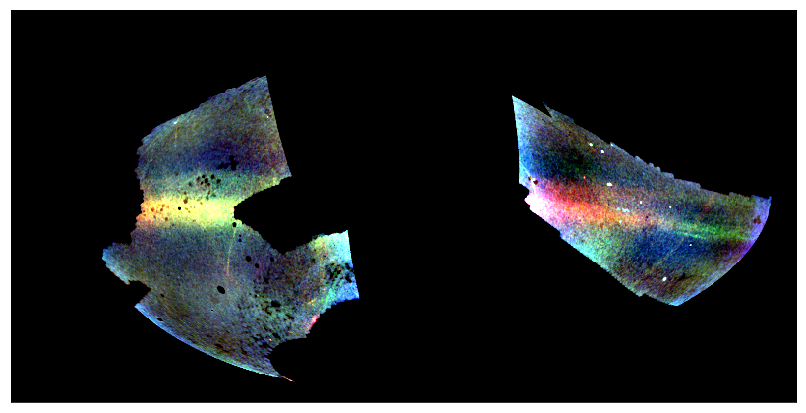

In [226]:
rgb = rgb_south

proj = hp.projector.MollweideProj(rot=rots['sag']) 
# proj = hp.projector.MollweideProj(rot=[0, 90, 0], xsize=1024)
# proj = plot_density_healpy.get_ortho_proj(ends=[[5,-5],[15,-5]], half_sky=False)
# proj = hp.projector.OrthographicProj(xsize=1024, rot=[0, 0, 0])

img = np.stack([proj.projmap(rgb[i].filled(), func) 
                for i in range(3)], axis=-1)

# img[~np.isfinite(img)] = 0

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.imshow(img, origin='bottom', extent=proj.get_extent())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
fig.tight_layout()

180.0 70.07010393543698 0.006632155190031799


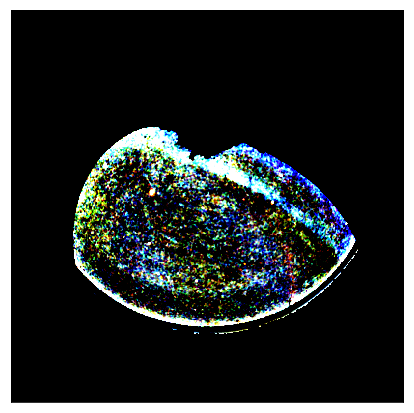

In [220]:
rgb = rgb_north

# proj = hp.projector.MollweideProj(rot=rots['sag']) 
# proj = hp.projector.MollweideProj(rot=[0, 90, 0], xsize=1024)
proj = plot_density_healpy.get_ortho_proj(ends=[[175,70],[185,70]], half_sky=True)
# proj = hp.projector.OrthographicProj(xsize=1024, rot=[0, 0, 0])

func = lambda x, y, z: hp.vec2pix(nside, x, y, z)

img = np.stack([proj.projmap(rgb[i].filled(), func) 
                for i in range(3)], axis=-1)

# img[~np.isfinite(img)] = 0

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.imshow(img, origin='bottom', extent=proj.get_extent())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
fig.tight_layout()

180.0 70.07010393543698 -0.006583871620510935


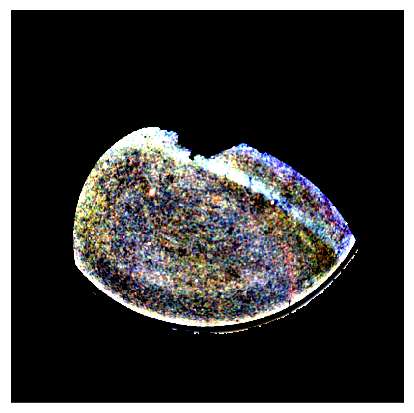

In [222]:
rgb = rgb_north

# proj = hp.projector.MollweideProj(rot=rots['sag']) 
# proj = hp.projector.MollweideProj(rot=[0, 90, 0], xsize=1024)
proj = plot_density_healpy.get_ortho_proj(ends=[[175,70],[185,70]], half_sky=True)
# proj = hp.projector.OrthographicProj(xsize=1024, rot=[0, 0, 0])

func = lambda x, y, z: hp.vec2pix(nside, x, y, z)

img = np.stack([proj.projmap(rgb[i].filled(), func) 
                for i in range(3)], axis=-1)

# img[~np.isfinite(img)] = 0

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.imshow(img, origin='bottom', extent=proj.get_extent())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
fig.tight_layout()

10.0 -5.019001817489642 0.005039454085494311


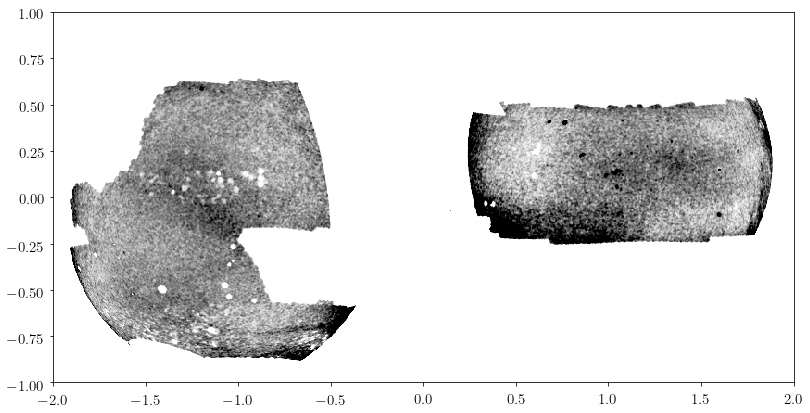

In [194]:
# ax = plot_density_healpy.plot_proj(proj, data_south-bkg_south, vmin=-2, vmax=2)
# mask = streamlib.make_mask(nside=512, lmc=True, sgr=False, acs=False, globs_dwarfs=False, dwarfs=True, globulars=True, milky_way=True)
# mask |= fracdet_south < 1
# mask_south = mask
# data = np.ma.array(data_stack_south[:,10], mask=mask_south)
# data = data_stack_south_masked[:,10]
# data = np.ma.array(data_stack_south[:,10], mask=mask_stack_south[:,10])
proj = plot_density_healpy.get_ortho_proj(ends=[[5,-5],[15,-5]], half_sky=False)
ax = plot_density_healpy.plot_proj(proj, data_stack_south_masked[:,10], vmin=-2, vmax=2)